# Машинное обучение, DS-поток
## Задание 1.6


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot` (ноутбуки `[0.1]_train_model.ipynb` и `[1.1]_modules.ipynb`).
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.
* Теоретические задачи необходимо оформить в LaTeX/markdown или же прислать фотку в правильной ориентации рукописного решения, **где все четко видно**.

**Баллы за задание:**

* Реализация модулей — 10 баллов.
* Применение на реальных данных — 5 баллов.

<h1 align=center>
    Welcome в Глубокое обучение!
</h1>

<img src="https://www.analyticsinsight.net/wp-content/uploads/2019/01/AutoML-1024x695.jpg" width=500>

В этом задании как и в прошлом, **используя только `NumPy`** нужно реализовать несколько модулей для построения нейронной сети. 

Структура задания подразумевает выполнение 3-х `jupyter notebook`'ов:

**`[0.1]_train_model.ipynb`**: текущий ноутбук. В нем поясняется суть задания, описаны остальные ноутбуки и именно этот ноутбук нужно запустить, когда все слои уже реализованы;

**`[1.1]_modules.ipynb`**: ноутбук, в котором нужно непосредственно реализовать слои нейронной сети. А именно:

> Базовые концепции:
- [x] `Module`     $-$ абстрактный класс для компонент нейронной сети;
- [x] `Sequential` $-$ класс, содержащий в себе последовательность объектов класса `Module`.

> Слои:
- [x] `Linear`     $-$ линейный слой;
- [x] `SoftMax`    $-$ слой, вычисляющий операцию *softmax*;
- [x] `LogSoftMax` $-$ слой, вычисляющий операцию *log(softmax)*;
- [ ] *(2 балла)* `Dropout` &mdash; слой дропаута;
- [ ] *(3 балла)* `BatchNormalization` &mdash; слой для работы с батч-нормализацией;
- [ ] *(1 балл)* `Scaling` &mdash; слой для работы с батч-нормализацией;
- [ ] *(1 балл)* `Flatten` &mdash; слой, который просто разворачивает тензор любой размерности в одномерный вектор.

> Функции активации (тоже являются слоями, но выделены в отдельную секцию для удобства):
- [x] `ReLU`      $-$ функция активации *Rectified Linear Unit*;
- [ ] *(1 балл)* `LeakyReLU` &mdash;  функция активации Leaky Rectified Linear Unit;
- [ ] *(1 балл)* `ELU` &mdash; функция активации *Exponential Linear Unit*;

> Функции потерь:
- [x] `Criterion`  $-$ абстрактный класс для функций потерь;
- [x] `NLLCriterionUnstable` $-$ negative log-likelihood функция потерь (нестабильная версия, возможны числовые переполнения);
- [x] `NLLCriterion` $-$ negative log-likelihood функция потерь (стабильная версия).

> Оптимизаторы:
- [x] `SGD`  $-$ алгоритм стохастического градиентного спуска.
- [ ] *(1 балл)* &mdash; любой другой оптимизатор, который мы разбирали на лекции.

**Галочками** помечены те слои, которые **уже реализованы за вас**. Таким образом, задание состоит в реализации оставшихся слоёв (мы заботимся о вашем здоровье 🍀). 

**`[2.1]_test_modules.ipynb`**: ноутбук с юнит-тестами, который следует использовать для отладки ноутбука **`[1.1]_modules.ipynb`**.

**Всего за задание можно получить:**
- **10 баллов** за `[1]task8_modules.ipynb`
- **5 баллов** за `[0]task8_train_model.ipynb` (этот ноутбук)
- Суммарно: **15 баллов**

---

In [1]:
# Путь к папке с заданием
path_to_dir = ''
# Путь к файлу с модулями
path_to_modules_notebook = path_to_dir + "[1.1]_modules.ipynb"

In [2]:
# В Google Colab подключаемся к диску
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_modules_notebook = "drive/MyDrive/" + path_to_modules_notebook

In [32]:
%run $path_to_modules_notebook

In [4]:
import time
from time import time, sleep
import warnings

from itertools import cycle, islice

from IPython import display

import numpy as np
import pandas as pd

import scipy.stats as sps

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.5)

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.optim import SGD as torch_sgd

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

## 1.2. Многоклассовая классификация: FashionMNIST (5 баллов = 2 + 2 + 1)

<p align=center>
<img src="https://www.researchgate.net/profile/Lina_Yao4/publication/325921786/figure/fig2/AS:640163516522496@1529638284313/Example-for-fashion-MNIST-Each-class-is-represented-by-nine-cases.png">
</p>

FashionMNIST $-$ это датасет, аналогичный MNIST'у (датасету рукописных цифр), но по своей сути чуть интереснее $-$ вместо цифр здесь элементы одежды. Это, конечно, не [DeepFashion](https://github.com/switchablenorms/DeepFashion2), но для проверки работы слоев подойдет.

Вместе с заданием идет архив `fashionmnist.zip`, распакуйте его в папку с этим ноутбуком (архив изначально скачан с [Kaggle Datasets](https://www.kaggle.com/zalando-research/fashionmnist)).

In [5]:
import subprocess

In [6]:
def upload_file_from_gdrive(gdrive_file_id, outfile) -> None:
    """
    Скачивает файл из Google Drive по ID.
    gdrive_file_id -- id файла на гугл-диске.
    outfile -- путь до файла, в котором будет сохранено изображение.
    """
    
    upload_cmd = (
        "wget --load-cookies /tmp/cookies.txt"
        " \"https://docs.google.com/uc?export=download&confirm=$("
        " wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies"
        f" --no-check-certificate 'https://docs.google.com/uc?export=download&id={gdrive_file_id}'"
        f" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\\1\\n/p')&id={gdrive_file_id}\" "
        f" -O {outfile} && rm -rf /tmp/cookies.txt"
    )
    subprocess.check_call(upload_cmd, shell=True)

def get_gdrive_file_id(link):
    return link.split('/')[5]

In [7]:
# Путь до zip-файла с даннными
ZIP_PATH = "fashionmnist.zip"

# Путь до папки с данными
DATA_PATH = "fashionmnist"

Работаю не в колабе, поэтому ошибка в следующей ячейке.

In [8]:
%%time

# Ссылка на архив с данными
link = "https://drive.google.com/file/d/1UR8L3k6iPZvyclzZTxt__KOeOMyb4h3g/view?usp=sharing"

# ID файла на диске
file_id = get_gdrive_file_id(link)
print("file ID:", file_id)

# Загрузка файла с диска
upload_file_from_gdrive(file_id, ZIP_PATH)
print(f"Данные загружены в {DATA_PATH}")

file ID: 1UR8L3k6iPZvyclzZTxt__KOeOMyb4h3g


CalledProcessError: Command 'wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$( wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UR8L3k6iPZvyclzZTxt__KOeOMyb4h3g' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1UR8L3k6iPZvyclzZTxt__KOeOMyb4h3g"  -O fashionmnist.zip && rm -rf /tmp/cookies.txt' returned non-zero exit status 1.

In [9]:
!unzip $ZIP_PATH

"unzip" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


В данном случае уже есть `.csv`-файлы, содержашие в себе "развернутые" в вектор-строку картинки (признаки) и столбец `label` (метки). Каждая картинка имеет размер $28 \times 28$. Значения (интенсивности цвета) в каждом пикселе $-$ целые числа от 0 до 255. 

Значения меток классов:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

In [11]:
train_df = pd.read_csv('FashionMNIST/fashion-mnist_train.csv')
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test_df = pd.read_csv('FashionMNIST/fashion-mnist_test.csv')
test_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


В трейне 60к картинок, в тесте 10к. В глубоком обучении и нейросетях в целом обычно не делают кросс-валидацию, потому что это долго и, следовательно, вычислительно затратно. Обычно выделяют `train`, `val` и `test` сеты: на `train` обучают, на `val` валидируют модели на предмет переобучения и подбирают гиперпараметры, на `test` измеряют итоговое качество. 

Убедимся, что данные уже перемешаны:

In [13]:
train_df['label'].values[:10]

array([2, 9, 6, 0, 3, 4, 4, 5, 4, 8], dtype=int64)

In [14]:
test_df['label'].values[:10]

array([0, 1, 2, 2, 3, 2, 8, 6, 5, 0], dtype=int64)

Как видим, данные уже перемешаны, так что просто выделим под валидацию 1/5 часть трейна:

In [15]:
val_start_idx = -int(len(train_df)/5)

train_df = train_df[:val_start_idx]
val_df = train_df[val_start_idx:]

print(train_df.shape, val_df.shape)

(48000, 785) (12000, 785)


Разделим признаки и метки:

In [16]:
train_sample = train_df.drop(axis=1, labels=['label']).values
train_labels = train_df['label'].values
val_sample = val_df.drop(axis=1, labels=['label']).values
val_labels = val_df['label'].values
test_sample = test_df.drop(axis=1, labels=['label']).values
test_labels = test_df['label'].values

print('Train:', train_sample.shape, train_labels.shape)
print('Val:', val_sample.shape, val_labels.shape)
print('Test:', test_sample.shape, test_labels.shape)

Train: (48000, 784) (48000,)
Val: (12000, 784) (12000,)
Test: (10000, 784) (10000,)


Сразу преобразуем метки в OneHot:

In [17]:
def make_onehot(labels):
    '''
    Практикуемся делать OneHot-кодирование на PyTorch
    '''
    num_classes = len(np.unique(labels))
    y = torch.LongTensor(labels.astype('int')).view(-1, 1)
    y_ohe = torch.FloatTensor(y.shape[0], num_classes)
    y_ohe.zero_()
    y_ohe.scatter_(1, y, 1)
    return y_ohe

In [18]:
y_train_ohe = make_onehot(train_labels).numpy()
y_val_ohe = make_onehot(val_labels).numpy()
y_test_ohe = make_onehot(test_labels).numpy()

print(train_labels.shape, y_train_ohe.shape)
print(train_labels[:10])
print(y_train_ohe[:10])

(48000,) (48000, 10)
[2 9 6 0 3 4 4 5 4 8]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


### Задание (2 балла)

Добейтесь точности не менее 0.85 на тестовой выборке c помощью модели, реализованной на `numpy`. Попробуйте добавить в архитектуру:
- `Dropout`
- `BatchNorm`
- `LeakyReLU`, `ELU`, `SoftPlus`
- Попробуйте разные связки выходного слоя и лосса: `LogSoftmax->NLLCriterion` и `Softmax->NLLCriterionUnstable`

Можете использовать уже реализованные для синтетических данных функции `train_generator`, `train_model`  и `test_generator`, `test_model` из прошлого задания. Не забудьте поменять `SGD` на свой оптимизатор. Аналоничные функции из прошлого задания можно использовать для модели на `pytorch` далее.

Архитекутра модели и гиперпараметры:

In [19]:
num_features = train_sample.shape[1]
num_classes = y_train_ohe.shape[1]
num_features, num_classes

(784, 10)

In [253]:
%run $path_to_modules_notebook

In [258]:
net = Sequential()
net.add(Linear(num_features, 128))
net.add(LeakyReLU())
net.add(BatchNormalization(alpha=0.1))
net.add(Scaling(128))
net.add(Linear(128, 32))
net.add(ELU())
net.add(BatchNormalization(alpha=0.1))
net.add(Scaling(32))
net.add(Dropout(p=0.15))
net.add(Linear(32, 10))
net.add(LogSoftMax())
print(net)

criterion = NLLCriterion()

optimizer_config = {'learning_rate' : 1e-3, 'mu': 0.9, 'beta': 0.9}
optimizer_state = {}

n_epoch = 10
batch_size = 128

Linear 784 -> 128
LeakyReLU
BatchNormalization
Scaling
Linear 128 -> 32
ELU
BatchNormalization
Scaling
Dropout
Linear 32 -> 10
LogSoftMax



In [259]:
def train_generator(sample, labels, batch_size):
    '''
    Генератор батчей. 
    На каждом шаге возвращает `batch_size` объектов из `sample` и их 
    меток из `labels`.
    '''
    n_samples = sample.shape[0]
    # Перемешиваем в случайном порядке в начале эпохи
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    # Обратите внимание на yield вместо return
    # (если раньше не сталкивались с генераторами)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx], labels[batch_idx]

In [260]:
def train_model(
    model, 
    sample, y,
    criterion,
    opt_params, 
    opt_state, 
    n_epoch, 
    batch_size
):
    '''
    Обучает модель из вашего мини-фреймворка. 
    Возвращает обученную модель, историю значений функции потерь 
    и метрики качества.
    
    :param `model`: модель из вашего мини-фреймворка
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `opt_state`: текущая информация о градиентах, 
                        хранящаяся в оптимизаторе
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''
    
    loss_history = []
    
    opt_params_2 = {'learning_rate' : 0.4}

    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            # Обнуляем градиенты с предыдущей итерации
            # Forward pass
            # Backward pass
            
            model.zero_grad_params()
            y_pred = model.forward(input=x_batch)
            loss = criterion.forward(input=y_pred, target=y_batch)
            grad = criterion.backward(input=y_pred, target=y_batch)
            model.backward(x_batch, grad)
#             <ВАШ КОД ЗДЕСЬ>
            
            # Обновление весов
            Adam(model.get_parameters(), 
                model.get_grad_params(), 
                opt_params,
                opt_state)
            loss_history.append(loss)

        display.clear_output(wait=True)
        
        plt.figure(figsize=(8, 6))
        plt.title("Функция потерь на train")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.plot(loss_history, 'b')
        plt.show()
        print('Current loss: %f' % loss)
    
    return model, loss_history

Обучение модели:

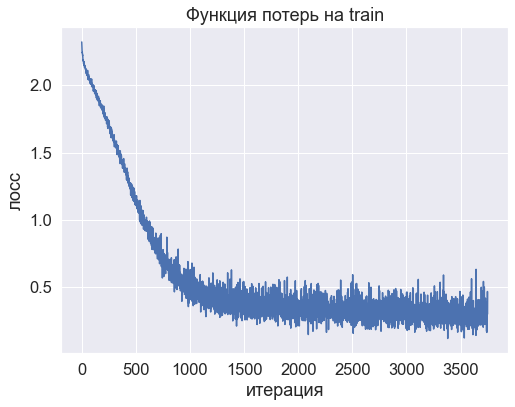

Current loss: 0.298867


In [261]:
net, loss_history = train_model(
    net, 
    train_sample, y_train_ohe, 
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

Предскажем на валидационной и тестовой выборке:

In [262]:
def test_model(model, test_sample):
    '''
    Тестирует модель на тестовой выборке.
    '''
    preds = []
    for test_batch in test_generator(test_sample):
        batch = model.forward(test_batch)
        batch = batch.argmax(axis=1).reshape(-1,1)
        preds.append(batch)
    preds = np.vstack(preds)
    return preds

In [263]:
def test_generator(sample):
    '''
    Батч-генератор для тестовых данных (без меток).
    '''
    n_samples = sample.shape[0]
    indices = np.arange(n_samples)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx]

In [305]:
val_predictions_my = test_model(net, val_sample)
print(val_predictions_my.shape)
test_predictions_my = test_model(net, test_sample)
print(test_predictions_my.shape)

(12000, 1)
(10000, 1)


In [306]:
print(
    f'Качество на Val моей собственной нейронной сети, обученной в течение {n_epoch} эпох: \
    {accuracy_score(val_labels, val_predictions_my):.3}'
)

Качество на Val моей собственной нейронной сети, обученной в течение 10 эпох:     0.897


In [307]:
print(
    f'Качество на Test моей собственной нейронной сети, обученной в течение {n_epoch} эпох: \
    {accuracy_score(test_labels, test_predictions_my):.3}'
)

Качество на Test моей собственной нейронной сети, обученной в течение 10 эпох:     0.879


Сравним с качеством аналогичной нейросети на PyTorch. Сначала обучим аналогичную torch-модель:

In [372]:
def train_model_torch(
    model, 
    sample, y,
    criterion,
    optimizer,
    n_epoch, 
    batch_size
):
    '''
    Обучает модель из PyTorch. 
    Возвращает обученную модель, историю значений функции потерь 
    и метрики качества.
    
    :param `model`: модель из PyTorch
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `opt_state`: текущая информация о градиентах, 
                        хранящаяся в оптимизаторе
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''
    
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            # Обнуляем градиенты с предыдущей итерации
            # Forward pass
            # Backward pass
            # Обновление весов
            optimizer.zero_grad()
            x_batch = x_batch.astype(np.float32)
            y_pred = model(input=torch.from_numpy(x_batch))
            y_pred = torch.FloatTensor(y_pred)
            loss = criterion(y_pred, torch.Tensor(y_batch).type(torch.LongTensor))
            loss.backward()
            optimizer.step()
            
            loss_history.append(loss.data)

        display.clear_output(wait=True)
        
        plt.figure(figsize=(8, 6))
        plt.title("Функция потерь на train")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.plot(loss_history, 'b')
        plt.show()
        print('Current loss: %f' % loss)
    
    return model, loss_history

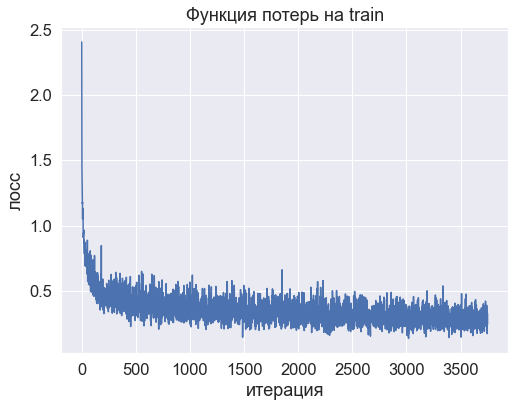

Current loss: 0.243637


In [373]:
net_torch = nn.Sequential()
net_torch.add_module('Linear 1', nn.Linear(num_features, 128))
net_torch.add_module('LeakyReLU', nn.LeakyReLU())
net_torch.add_module('BatchNorm 1', nn.BatchNorm1d(128))
net_torch.add_module('Linear 2', nn.Linear(128, 32))
net_torch.add_module('ELU', nn.ELU())
net_torch.add_module('BatchNorm 2', nn.BatchNorm1d(32))
net_torch.add_module('Dropout', nn.Dropout(p=0.15))
net_torch.add_module('Linear 3', nn.Linear(32, 10))
net_torch.add_module('LogSoftMax', nn.LogSoftmax())

print(net_torch)

criterion = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(net_torch.parameters(), lr=0.001)

net_torch, loss_history = train_model_torch(
    net_torch, 
    train_sample, train_labels, 
    criterion,
    optimizer,
    n_epoch,
    batch_size
)

Сделаем предсказания и посчитаем метрику качества:

In [374]:
def test_torch(model, test_sample):
    '''
    Тестирует модель из PyTorch на тестовой выборке.
    '''
    preds = []
    with torch.no_grad():
        for test_batch in test_generator(test_sample):
            preds_batch = model(torch.FloatTensor(test_batch))
            preds_batch = preds_batch.argmax(axis=1).reshape(-1,1)
            preds.append(preds_batch.detach().numpy())
    preds = np.vstack(preds)
    return preds

In [377]:
val_predictions_torch = test_torch(net_torch, val_sample)
print(val_predictions_torch.shape)
test_predictions_torch = test_torch(net_torch, test_sample)
print(test_predictions_torch.shape)

(12000, 1)
(10000, 1)


In [378]:
print(
    f'Качество на Val нейронной сети из PyTorch, обученной в течение {n_epoch} эпох: \
    {accuracy_score(val_labels, val_predictions_torch):.3}'
)

Качество на Val нейронной сети из PyTorch, обученной в течение 10 эпох:     0.896


In [379]:
print(
    f'Качество на Test нейронной сети из PyTorch, обученной в течение {n_epoch} эпох: \
    {accuracy_score(test_labels, test_predictions_torch):.3}'
)

Качество на Test нейронной сети из PyTorch, обученной в течение 10 эпох:     0.876


**Вывод:** результаты моей модели и модели из торча получились примерно одинаковыми. В обеих моделях мы использовали 3 линейных слоя, 2 вида ReLU, 2 батчнорма, ближе к концу дропаут и в конце логсофтмакс, чтобы перейти к минимизации устойчивого NLL. После первых слоев мы применяли функцию активации (причем, не саму ReLU, так как могла возникнуть Dying ReLU problem), далее нормализовывали (боролись с ковариантным сдвигом), а в конце пытались бороться с переобучением с помощью слоя дропаут.

Сейчас мы подавали в нейросеть "сырые" значения в пикселях. В компьютерном зрении обычно их масштабируют (нормализуют), чтобы значения во входном тензоре были от 0 до 1. Попробуйте поделить обучающую выборку на максимальное значение интенсивности пикселя и обучить сети (не забудьте отмасштабировать значения в тестовых тензорах тоже). Улучшилось/ухудшилось итогвое качество нейросетей? Как вы думаете, почему?

Также, как и всегда ранее, полезно поиграться со значениями гиперпараметров (количество нейронов в скрытом слое, `learning_rate` и т.д.).

In [386]:
max_pixel = train_sample.max()

scaled_train_sample = train_sample / max_pixel
scaled_val_sample = val_sample / max_pixel
scaled_test_sample = test_sample / max_pixel

Моя сетка:

In [387]:
net = Sequential()
net.add(Linear(num_features, 128))
net.add(LeakyReLU())
net.add(BatchNormalization(alpha=0.1))
net.add(Scaling(128))
net.add(Linear(128, 32))
net.add(ELU())
net.add(BatchNormalization(alpha=0.1))
net.add(Scaling(32))
net.add(Dropout(p=0.15))
net.add(Linear(32, 10))
net.add(LogSoftMax())
print(net)

criterion = NLLCriterion()

optimizer_config = {'learning_rate' : 1e-3, 'mu': 0.9, 'beta': 0.9}
optimizer_state = {}

n_epoch = 10
batch_size = 128

Linear 784 -> 128
LeakyReLU
BatchNormalization
Scaling
Linear 128 -> 32
ELU
BatchNormalization
Scaling
Dropout
Linear 32 -> 10
LogSoftMax



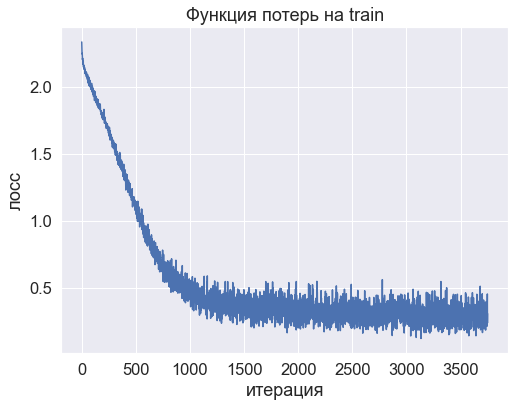

Current loss: 0.311367


In [388]:
net, loss_history = train_model(
    net, 
    scaled_train_sample, y_train_ohe, 
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

In [389]:
val_predictions_my = test_model(net, scaled_val_sample)
print(val_predictions_my.shape)
test_predictions_my = test_model(net, scaled_test_sample)
print(test_predictions_my.shape)

(12000, 1)
(10000, 1)


In [390]:
print(
    f'Качество на Val моей собственной нейронной сети, обученной в течение {n_epoch} эпох: \
    {accuracy_score(val_labels, val_predictions_my):.3}'
)

Качество на Val моей собственной нейронной сети, обученной в течение 10 эпох:     0.901


In [391]:
print(
    f'Качество на Test моей собственной нейронной сети, обученной в течение {n_epoch} эпох: \
    {accuracy_score(test_labels, test_predictions_my):.3}'
)

Качество на Test моей собственной нейронной сети, обученной в течение 10 эпох:     0.88


Сетка torch:

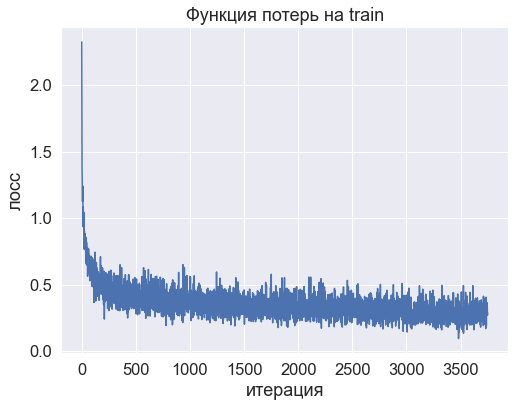

Current loss: 0.290337


In [393]:
net_torch = nn.Sequential()
net_torch.add_module('Linear 1', nn.Linear(num_features, 128))
net_torch.add_module('LeakyReLU', nn.LeakyReLU())
net_torch.add_module('BatchNorm 1', nn.BatchNorm1d(128))
net_torch.add_module('Linear 2', nn.Linear(128, 32))
net_torch.add_module('ELU', nn.ELU())
net_torch.add_module('BatchNorm 2', nn.BatchNorm1d(32))
net_torch.add_module('Dropout', nn.Dropout(p=0.15))
net_torch.add_module('Linear 3', nn.Linear(32, 10))
net_torch.add_module('LogSoftMax', nn.LogSoftmax())

print(net_torch)

criterion = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(net_torch.parameters(), lr=0.001)

net_torch, loss_history = train_model_torch(
    net_torch, 
    scaled_train_sample, train_labels, 
    criterion,
    optimizer,
    n_epoch,
    batch_size
)

In [394]:
val_predictions_torch = test_torch(net_torch, scaled_val_sample)
print(val_predictions_torch.shape)
test_predictions_torch = test_torch(net_torch, scaled_test_sample)
print(test_predictions_torch.shape)

(12000, 1)
(10000, 1)


In [395]:
print(
    f'Качество на Val нейронной сети из PyTorch, обученной в течение {n_epoch} эпох: \
    {accuracy_score(val_labels, val_predictions_torch):.3}'
)

Качество на Val нейронной сети из PyTorch, обученной в течение 10 эпох:     0.897


In [396]:
print(
    f'Качество на Test нейронной сети из PyTorch, обученной в течение {n_epoch} эпох: \
    {accuracy_score(test_labels, test_predictions_torch):.3}'
)

Качество на Test нейронной сети из PyTorch, обученной в течение 10 эпох:     0.873


**Вывод:** видно, что на нормализованных данных метрика в обоих сетях почти не поменялась, значит, обе сетки умеют одинаково хорошо работать с данными разных масштабов.

### Задание (2 балла)

Является ли разница в качестве вашей нейросети и сети на PyTorch статистически значимой? Проверьте, написав код/формулы в ячейках ниже.

Кажется, мы этого еще не прошли, и нам разрешили это не делать.

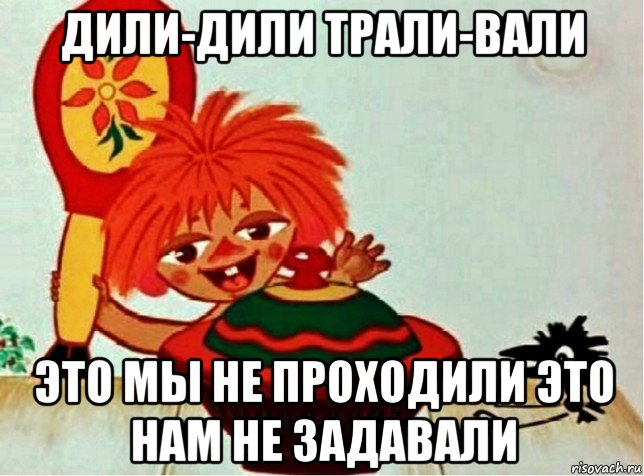

In [380]:
# <ВАШ КОД ЗДЕСЬ>

### Задание (1 балл)

Выберите случайные 5 картинок и предскажите для них вероятности. Нарисуйте для каждой картинки в строчку:
1. Саму картинку
2. Гистограмму оценок вероятностей, которые получаются на выходе

*Примечание:* Удобно вывести по оси X названия классов вместо чисел. Соответствие классов номерам см. выше. 

In [405]:
id_to_name = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def plot_image_hist(pixel_vector, probas, true_label=None, figsize=(15,50)):
    plt.figure(figsize=figsize)
    
    for i, vec in enumerate(pixel_vector):
        plt.subplot(pixel_vector.shape[0], 2, 2 * i + 1)
        plt.imshow(vec.reshape((28, 28)))
        plt.title(f'Картинка вещи. Настоящий лейбл: {id_to_name[true_label[i]]}')
        
        plt.subplot(pixel_vector.shape[0], 2, 2 * i + 2)
        plt.bar(x=np.linspace(0, 9, 10, dtype=int), height=probas[i])
        plt.xticks(np.linspace(0, 9, 10, dtype=int), labels=np.linspace(0, 9, 10, dtype=int))
        plt.title(f'Гистограмма оценок вероятностей на выходе. Правильный номер лейбла: {true_label[i]}')

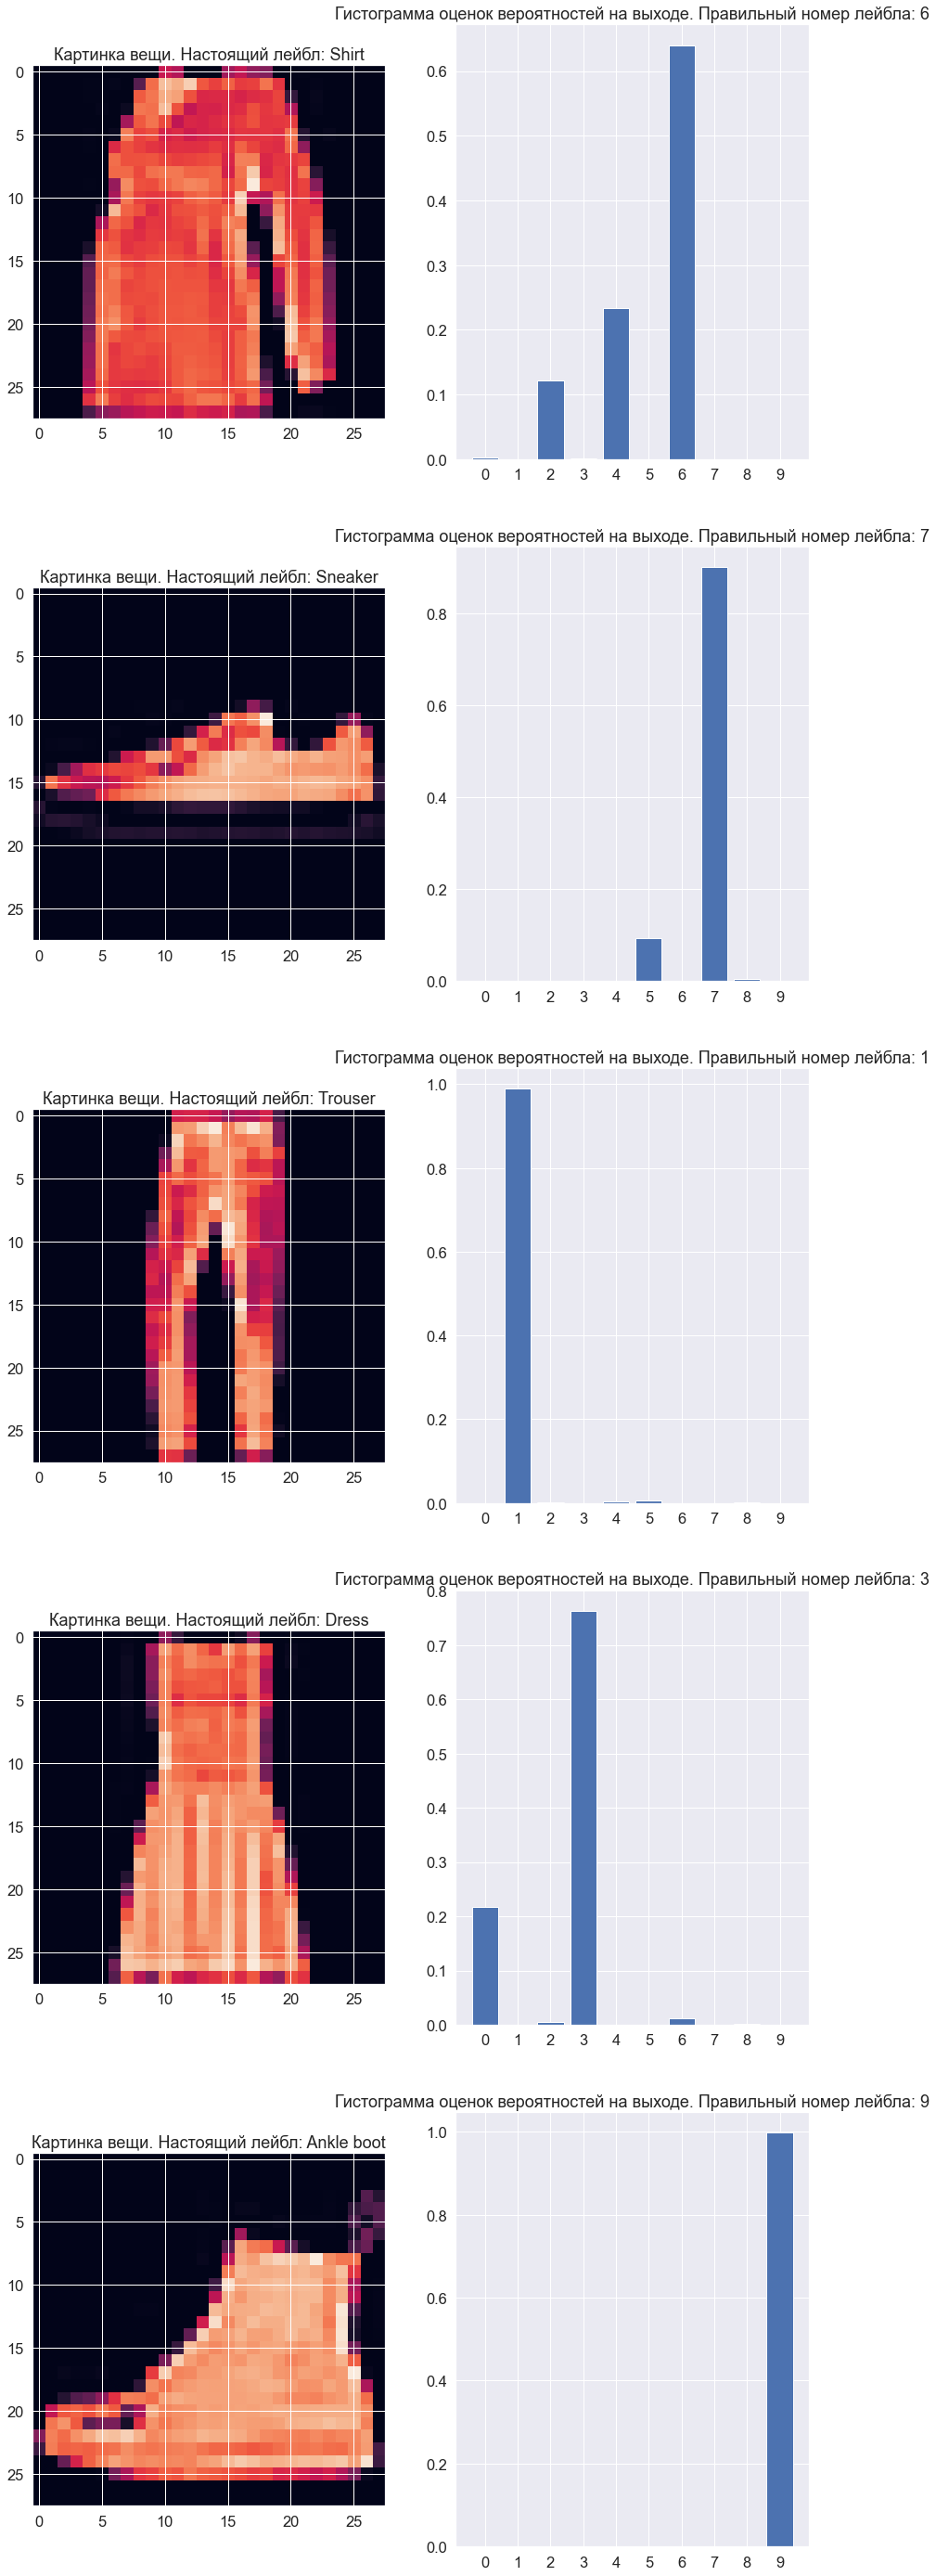

In [406]:
import random
index=random.sample(range(len(test_sample)),5)
pixel_vector=test_sample[index]
probas= torch.exp(net_torch(torch.FloatTensor(pixel_vector)))
probas=probas.detach().numpy()
plot_image_hist(pixel_vector, probas=probas, true_label=test_labels[index])

**Вывод:** выбрав 5 случайных картинок из теста, мы посмотрели, насколько уверенно модель предсказывает на них лейбл. Оказалось, что модель довольно уверена в своих предсказаниях (везде вероятность правильного таргета больше 0.6), при этом на предложенных 5 картинках всегда предсказывает правильный таргет, что является неплохим результатом.

## Послесловие

Возможно, вам кажется, что вы построили какую-то игрушечную нейросеть, которая неспособна работать в "реальных" задачах. **Это не так.**

То, что вы реализовали, по сути составляет основную часть фреймворка PyTorch. Да, там реализовано еще много трюков для более эффективных вычислений, `autograd` и работа с GPU, но суть та же $-$ модули, где каждый предоставляет forward и backward (с помощь `autograd`).

В этом задании вы оперировали в основном полносвязными (`Linear`) слоями, чаще их называют Fully-Connected (FC). Они активно применяются и по сей день:
- В задачах компьютерного зрения (CV): как слои классификации в "голове" сверточных нейросетей 
- В задачах обработки естественного языка (NLP): как слои attention'а в Transformer'е
- В Reinforcement Learning (RL) иногда делают архитектуры исключительно из FC-слоев

## Полезные ссылки

При составлении этого Домашнего задания авторы вдохновлялись [заданием](https://github.com/yandexdataschool/Practical_DL/tree/spring2019/homework01) из курса "Deep Learning" Школы Анализа Данных.

- [Заметки главы ИИ в Tesla Andrej Karpathy по обучению нейросетей](http://karpathy.github.io/2019/04/25/recipe/)
- [Backpropagation на brilliant.org](https://brilliant.org/wiki/backpropagation/)
- См. ссылки в `[1]task8_modules.ipynb`